In [ ]:
!pip install llvmlite --ignore-installed

In [ ]:
!pip install mxnet==1.9
# !pip install mxnet-cu112==1.9

In [ ]:
!pip install autogluon

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame

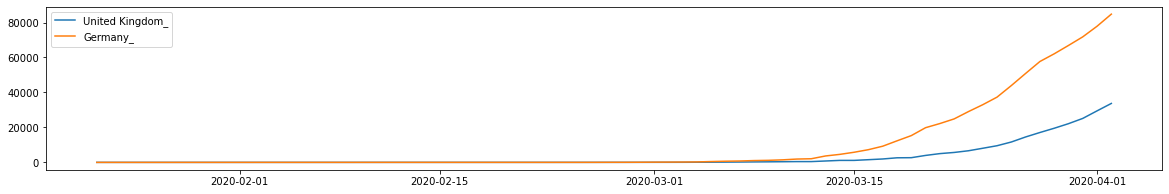

In [2]:
df = pd.read_csv(
    "https://autogluon.s3-us-west-2.amazonaws.com/datasets/CovidTimeSeries/train.csv",
    parse_dates=["Date"],
)

train_data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="name",
    timestamp_column="Date",
)

plt.figure(figsize=(20, 3))
for country in ["United Kingdom_", "Germany_"]:
    plt.plot(train_data.loc[country], label=country)
plt.legend()

In [5]:
train_data.info()

<class 'autogluon.timeseries.dataset.ts_dataframe.TimeSeriesDataFrame'>
MultiIndex: 22536 entries, ('Afghanistan_', Timestamp('2020-01-22 00:00:00')) to ('Zimbabwe_', Timestamp('2020-04-02 00:00:00'))
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ConfirmedCases  22536 non-null  float64
dtypes: float64(1)
memory usage: 255.4+ KB


In [3]:
train_data.head()

ConfirmedCases
item_id      timestamp                 
Afghanistan_ 2020-01-22             0.0
             2020-01-23             0.0
             2020-01-24             0.0
             2020-01-25             0.0
             2020-01-26             0.0

In [6]:
train_data.loc['Afghanistan_'].head()

,ConfirmedCases
timestamp,
2020-01-22,0.0
2020-01-23,0.0
2020-01-24,0.0
2020-01-25,0.0
2020-01-26,0.0


In [7]:
prediction_length = 5

test_data = train_data.copy()  # the full data set

# the data set with the last prediction_length time steps included, i.e., akin to `a[:-5]`
train_data = train_data.slice_by_timestep(slice(None, -prediction_length))

In [8]:
predictor = TimeSeriesPredictor(
    path="autogluon-covidforecast",
    target="ConfirmedCases",
    prediction_length=prediction_length,
    eval_metric="MAPE",
)
predictor.fit(
    train_data=train_data,
    presets="low_quality",
)

presets is set to low_quality
================ TimeSeriesPredictor ================
TimeSeriesPredictor.fit() called
Setting presets to: low_quality
Fitting with arguments:
{'evaluation_metric': 'MAPE',
 'hyperparameter_tune_kwargs': None,
 'hyperparameters': 'toy',
 'prediction_length': 5,
 'target_column': 'ConfirmedCases',
 'time_limit': None}
Provided training data set with 20971 rows, 313 items. Average time series length is 67.0.
Training artifacts will be saved to: /home/ec2-user/SageMaker/gluonts_sagemaker/autogluon-covidforecast
Validation data is None, will hold the last prediction_length 5 time steps out to use as validation set.

Starting training. Start time is 2022-06-27 02:19:16
Models that will be trained: ['AutoETS', 'SimpleFeedForward', 'DeepAR', 'MQCNN']
Training timeseries model AutoETS. 
	-0.3287       = Validation score (-MAPE)
	4.23    s     = Training runtime
	26.38   s     = Validation (prediction) runtime
Training timeseries model SimpleFeedForward. 
	-0.5227 

In [9]:
predictor.leaderboard(test_data, silent=True)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).
Different set of items than those provided during training were provided for prediction. The model AutoETS will be re-trained on newly provided data
Different set of items than those provided during training were provided for prediction. The model AutoETS will be re-trained on newly provided data


,model,score_test,score_val,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-0.218158,-0.309665,28.177627,125.567085,5
1,AutoETS,-0.247532,-0.328701,26.384829,4.232892,1
2,SimpleFeedForward,-0.280825,-0.522697,1.676183,2.589172,2
3,DeepAR,-0.450741,-0.978491,2.787163,4.817754,3
4,MQCNN,-0.652753,-0.749017,1.792798,3.674393,4


In [10]:
predictions = predictor.predict(train_data)

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble
Different set of items than those provided during training were provided for prediction. The model AutoETS will be re-trained on newly provided data


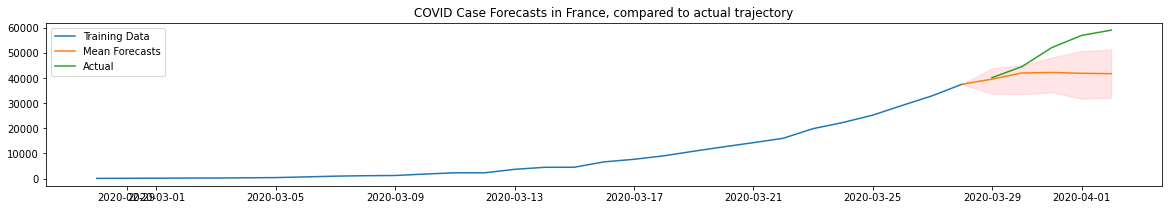

In [11]:
plt.figure(figsize=(20, 3))

ytrue = train_data.loc['France_']["ConfirmedCases"]
ypred = predictions.loc['France_']

# prepend the last value of true range to predicted range for plotting continuity
ypred.loc[ytrue.index[-1]] = [ytrue[-1]] * 10
ypred = ypred.sort_index()

ytrue_test = test_data.loc['France_']["ConfirmedCases"][-5:]

plt.plot(ytrue[-30:], label="Training Data")
plt.plot(ypred["mean"], label="Mean Forecasts")
plt.plot(ytrue_test, label="Actual")

plt.fill_between(
    ypred.index, ypred["0.1"], ypred["0.9"], color="red", alpha=0.1
)
plt.title("COVID Case Forecasts in France, compared to actual trajectory")
_ = plt.legend()